In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
import warnings; warnings.simplefilter('ignore')

In [2]:
# Central Piecewise Mechanism for a numeric query

def eta(c,l,r):
    return (2/r)*c - (2*l+r)/r

def inverse_eta(z,l,r):
    return (r/2)*z + (2*l+r)/2

def CPM(epsilon, fx, l, r, sensitivity):
    # Mapping Step
    t = eta(fx,l,r)
    tild_sensitivity = (2/r)*sensitivity
    m = 0
    while(1):
        if m < 2/tild_sensitivity <= m+1:
            break
        else:
            m += 1
    
    # Perturbation Step
    A = tild_sensitivity*(math.exp(epsilon)*(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1))
    B = (1 + m*tild_sensitivity)*math.exp((m+1)*epsilon)
    U = epsilon/math.log((A + math.sqrt(A**2 + 4*B))/2)
    b = ((m+3)/(m+4))*U
    
    q = (math.exp(epsilon/b)/(2*((math.exp(epsilon/b)+1)**2)*(math.exp(epsilon)-1)))*((math.exp(epsilon)-1)*(math.exp((m+1)*epsilon)-1)-tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*(m*math.exp((m+1)*epsilon)-(m+1)*math.exp(m*epsilon)+1))
    X = math.exp((m+1)*epsilon)/(2*q*(math.exp(epsilon/b)+1))
    Y = np.zeros(m+2)
    for j in range(1,m+2):
        Y[j] = (1/(2*q))*(math.exp(epsilon/b)/(math.exp(epsilon/b)+1))*(1+tild_sensitivity*(math.exp(epsilon)/math.exp(epsilon/b))*((m+1-j)*math.exp(m*epsilon)-(math.exp(m*epsilon)-1)/(math.exp(epsilon)-1)))
    D = X + Y[1]
    
    u = random.uniform(0,1)
    flag = 0
    if u < (q/math.exp((m+1)*epsilon))*(X*t-Y[1]+D):
        tt = random.uniform(-D,X*t-Y[1])
        flag = 1
    p = (q/math.exp((m+1)*epsilon))*(X*t-Y[1]+D)
    for j in range(1,m+1):
        p += (q/math.exp((m+1-j)*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t-Y[j],X*t-Y[j+1])
            flag = 1
    p += q*2*Y[m+1]
    if flag == 0 and u < p:
        tt = random.uniform(X*t-Y[m+1],X*t+Y[m+1])
        flag = 1
    for j in range(1,m+1):
        p += (q/math.exp(j*epsilon))*X*tild_sensitivity
        if flag == 0 and u < p:
            tt = random.uniform(X*t+Y[m+2-j],X*t+Y[m+1-j])
            flag = 1
    if flag == 0:
        tt = random.uniform(X*t+Y[1],D)
        flag = 1
    
    # Inverse Mapping
    p_fx = inverse_eta(tt,l,r)
    
    return p_fx

In [3]:
def SubOptimal(eps,m,p_eps1):
    k = 2
    
    tild_sensitivity = np.zeros(k+1)
    for j in range(1,k+1):
        tild_sensitivity[j] = 2/(m[j]+1)
        
    b = np.zeros(k+1)
    for j in range(1,k+1):
        A = tild_sensitivity[j]*(math.exp(eps[j])*(math.exp(m[j]*eps[j])-1)/(math.exp(eps[j])-1))
        B = (1 + m[j]*tild_sensitivity[j])*math.exp((m[j]+1)*eps[j])
        U = eps[j]/math.log((A + math.sqrt(A**2 + 4*B))/2)
        b[j] = ((m[j]+3)/(m[j]+4))*U
        
    X = np.zeros(k+1)
    Y = np.zeros((k+1,max(m)+2))
    for j in range(1,k+1):
        q = (math.exp(eps[j]/b[j])/(2*((math.exp(eps[j]/b[j])+1)**2)*(math.exp(eps[j])-1)))*((math.exp(eps[j])-1)*(math.exp((m[j]+1)*eps[j])-1)-tild_sensitivity[j]*(math.exp(eps[j])/math.exp(eps[j]/b[j]))*(m[j]*math.exp((m[j]+1)*eps[j])-(m[j]+1)*math.exp(m[j]*eps[j])+1))
        X[j] = math.exp((m[j]+1)*eps[j])/(2*q*(math.exp(eps[j]/b[j])+1))
        for i in range(1,m[j]+2):
            Y[j][i] = (1/(2*q))*(math.exp(eps[j]/b[j])/(math.exp(eps[j]/b[j])+1))*(1+tild_sensitivity[j]*(math.exp(eps[j])/math.exp(eps[j]/b[j]))*((m[j]+1-i)*math.exp(m[j]*eps[j])-(math.exp(m[j]*eps[j])-1)/(math.exp(eps[j])-1)))
        
    d = np.zeros((k+1,max(m)+2))
    for j in range(1,k+1):
        d[j][0] = 2*X[j]
        for i in range(1,m[j]+1):
            d[j][i] = 2*(Y[j][i]-Y[j][i+1])
        d[j][m[j]+1] = 2*Y[j][m[j]+1]
    #print(d)
    
    N = np.zeros((m[1]+2,m[2]+2))
    for i in range(m[1]+2):
        for j in range(m[2]+2):
            N[i][j] = d[1][i]*d[2][j]
    #print(N)
    
    p0 = np.ones(2*m[1]+2*m[2]+5)*(1/(2*m[1]+2*m[2]+4))
    p0[2*m[1]+2*m[2]+4] = math.exp(np.sum(eps)*0.9)
    fun = lambda p: p[2*m[1]+2*m[2]+4]
    
    cons = ()
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[i] for i in range(2*m[1]+2*m[2]+4)) + np.sum(p[m[1]+j]*(N[m[1]-i][j]/N[m[1]][j])*(1/math.exp(p_eps1*i)) for i in range(1,m[1]+1) for j in range(m[2])) - 1},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: p[0] + p[m[1]+m[2]+1] + np.sum(p[m[1]+j]*(N[0][j]/N[m[1]][j])*(1/math.exp(p_eps1*m[1])) for j in range(m[2])) - 1/(math.exp(eps[1]/b[1])+1)},)
    for i in range(1,m[1]):
        cons = cons + ({'type': 'eq', 'fun': lambda p, i=i: p[i] + p[m[1]+m[2]+1+i] + np.sum(p[m[1]+j]*(N[i][j]/N[m[1]][j])*(1/math.exp(p_eps1*(m[1]-i))) for j in range(m[2])) - tild_sensitivity[1]*(math.exp(i*eps[1])/(math.exp(eps[1]/b[1])+1))},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[i] for i in range(m[1],m[1]+m[2]+1)) + p[2*m[1]+m[2]+1] - tild_sensitivity[1]*(math.exp(m[1]*eps[1])/(math.exp(eps[1]/b[1])+1))},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[m[1]]*(N[i][0]/N[m[1]][0])*(1/math.exp(p_eps1*(m[1]-i))) for i in range(m[1]+1)) + p[2*m[1]+m[2]+2] - 1/(math.exp(eps[2]/b[2])+1)},)
    for j in range(1,m[2]):
        cons = cons + ({'type': 'eq', 'fun': lambda p, j=j: np.sum(p[m[1]+j]*(N[i][j]/N[m[1]][j])*(1/math.exp(p_eps1*(m[1]-i))) for i in range(m[1]+1)) + p[2*m[1]+m[2]+2+j] - tild_sensitivity[2]*(math.exp(j*eps[2])/(math.exp(eps[2]/b[2])+1))},)
    cons = cons + ({'type': 'eq', 'fun': lambda p: np.sum(p[i] for i in range(m[1])) + p[m[1]+m[2]] + p[2*m[1]+2*m[2]+2] - tild_sensitivity[2]*(math.exp(m[2]*eps[2])/(math.exp(eps[2]/b[2])+1))},)
    
    for i in range(m[1]):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[i]/N[i][m[2]]) - (p[m[1]+m[2]-1]/N[m[1]][m[2]-1])*(1/math.exp(p_eps1*(m[1]-i)))},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[m[1]+m[2]+1+i]/N[i][m[2]+1]) - (p[i]/N[i][m[2]])},)
    for i in range(m[1]-1):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[i+1]/N[i+1][m[2]]) - (p[i]/N[i][m[2]])},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: (p[m[1]+m[2]+2+i]/N[i+1][m[2]+1]) - (p[m[1]+m[2]+1+i]/N[i][m[2]+1])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[m[1]+m[2]]/N[m[1]][m[2]]) - (p[m[1]-1]/N[m[1]-1][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1]) - (p[2*m[1]+m[2]]/N[m[1]-1][m[2]+1])},)
    for j in range(m[2]):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: (p[m[1]+j+1]/N[m[1]][j+1]) - (p[m[1]+j]/N[m[1]][j])},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: (p[2*m[1]+m[2]+3+j]/N[m[1]+1][j+1]) - (p[2*m[1]+m[2]+2+j]/N[m[1]+1][j])},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: (p[2*m[1]+m[2]+2+j]/N[m[1]+1][j]) - (p[m[1]+j]/N[m[1]][j])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1]) - (p[m[1]+m[2]]/N[m[1]][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+2*m[2]+2]/N[m[1]+1][m[2]]) - (p[m[1]+m[2]]/N[m[1]][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+2*m[2]+3]/N[m[1]+1][m[2]+1]) - (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: (p[2*m[1]+2*m[2]+3]/N[m[1]+1][m[2]+1]) - (p[2*m[1]+2*m[2]+2]/N[m[1]+1][m[2]])},)
    
    for i in range(m[1]-1):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: p[2*m[1]+2*m[2]+4] - math.exp(p_eps1*(m[1]-i))*((p[i+1]/N[i+1][m[2]])/(p[m[1]+m[2]-1]/N[m[1]][m[2]-1]))},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, i=i: p[2*m[1]+2*m[2]+4] - (p[m[1]+m[2]+2+i]/N[i+1][m[2]+1])/(p[i]/N[i][m[2]])},)
    for j in range(m[2]):
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: p[2*m[1]+2*m[2]+4] - math.exp(p_eps1)*((p[m[1]+j+1]/N[m[1]][j+1])/(p[m[1]+j]/N[m[1]][j]))},)
        cons = cons + ({'type': 'ineq', 'fun': lambda p, j=j: p[2*m[1]+2*m[2]+4] - (p[2*m[1]+m[2]+3+j]/N[m[1]+1][j+1])/(p[m[1]+j]/N[m[1]][j])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: p[2*m[1]+2*m[2]+4] - (p[2*m[1]+m[2]+1]/N[m[1]][m[2]+1])/(p[m[1]-1]/N[m[1]-1][m[2]])},)
    cons = cons + ({'type': 'ineq', 'fun': lambda p: p[2*m[1]+2*m[2]+4] - (p[2*m[1]+2*m[2]+3]/N[m[1]+1][m[2]+1])/(p[m[1]+m[2]]/N[m[1]][m[2]])},)
        
    
    bnds = [(0,1)]*(2*m[1]+2*m[2]+5)
    bnds[2*m[1]+2*m[2]+4] = (0,np.inf)
    
    res = minimize(fun, p0, bounds=bnds, constraints=cons)
    if res.message == 'Inequality constraints incompatible' or res.fun < math.exp(p_eps1):
        return math.exp(np.sum(eps)), [100,100]
    else:
        return res.fun, res.x

In [4]:
f = open('BR.txt', 'r')
data = f.read()
print(data[0:23])
print(len(data)/22)

000008710009990001000
0
20635472.0


In [5]:
v = np.zeros(20635472)
for i in range(len(v)):
    v[i] = data[int(22*i):int(22*(i+1)-1)]
#print(v[0])

d = np.zeros((2,20635472))
top10 = np.ones((2,10))*(-1)

for i in range(20635472):
    # Number of children ever born
    d[0][i] = int(int(v[i]/100000000)%100)
    if d[0][i] == 98 or d[0][i] == 99:
        d[0][i] = 0
    d[0][i] = d[0][i]/15 - 1
    if top10[0][0] < d[0][i]:
        for j in range(9):
            top10[0][9-j] = top10[0][8-j]
        top10[0][0] = d[0][i]
    elif top10[0][1] < d[0][i]:
        for j in range(8):
            top10[0][9-j] = top10[0][8-j]
        top10[0][1] = d[0][i]
    elif top10[0][2] < d[0][i]:
        for j in range(7):
            top10[0][9-j] = top10[0][8-j]
        top10[0][2] = d[0][i]
    elif top10[0][3] < d[0][i]:
        for j in range(6):
            top10[0][9-j] = top10[0][8-j]
        top10[0][3] = d[0][i]
    elif top10[0][4] < d[0][i]:
        for j in range(5):
            top10[0][9-j] = top10[0][8-j]
        top10[0][4] = d[0][i]
    elif top10[0][5] < d[0][i]:
        for j in range(4):
            top10[0][9-j] = top10[0][8-j]
        top10[0][5] = d[0][i]
    elif top10[0][6] < d[0][i]:
        for j in range(3):
            top10[0][9-j] = top10[0][8-j]
        top10[0][6] = d[0][i]
    elif top10[0][7] < d[0][i]:
        for j in range(2):
            top10[0][9-j] = top10[0][8-j]
        top10[0][7] = d[0][i]
    elif top10[0][8] < d[0][i]:
        for j in range(1):
            top10[0][9-j] = top10[0][8-j]
        top10[0][8] = d[0][i]
    elif top10[0][9] < d[0][i]:
        top10[0][9] = d[0][i]
    
    # total income
    d[1][i] = int(v[i]%10000000)
    d[1][i] = d[1][i]/5000000 - 1
    if top10[1][0] < d[1][i]:
        for j in range(9):
            top10[1][9-j] = top10[1][8-j]
        top10[1][0] = d[1][i]
    elif top10[1][1] < d[1][i]:
        for j in range(8):
            top10[1][9-j] = top10[1][8-j]
        top10[1][1] = d[1][i]
    elif top10[1][2] < d[1][i]:
        for j in range(7):
            top10[1][9-j] = top10[1][8-j]
        top10[1][2] = d[1][i]
    elif top10[1][3] < d[1][i]:
        for j in range(6):
            top10[1][9-j] = top10[1][8-j]
        top10[1][3] = d[1][i]
    elif top10[1][4] < d[1][i]:
        for j in range(5):
            top10[1][9-j] = top10[1][8-j]
        top10[1][4] = d[1][i]
    elif top10[1][5] < d[1][i]:
        for j in range(4):
            top10[1][9-j] = top10[1][8-j]
        top10[1][5] = d[1][i]
    elif top10[1][6] < d[1][i]:
        for j in range(3):
            top10[1][9-j] = top10[1][8-j]
        top10[1][6] = d[1][i]
    elif top10[1][7] < d[1][i]:
        for j in range(2):
            top10[1][9-j] = top10[1][8-j]
        top10[1][7] = d[1][i]
    elif top10[1][8] < d[1][i]:
        for j in range(1):
            top10[1][9-j] = top10[1][8-j]
        top10[1][8] = d[1][i]
    elif top10[1][9] < d[1][i]:
        top10[1][9] = d[1][i]

ATP = np.zeros(2)
for i in range(2):
    ATP[i] = (np.sum(top10[i]))/10

In [6]:
def evaluation(m,e,run,ATP):
    k = 2; l = -1; r = 2; sensitivity = [2/(m[l]+1) for l in range(k+1)]
    beps = [0.4,0.8,1.2,1.6,2.0,2.4,2.8,3.2,3.6]
    diff = np.zeros((9,2))
    fx = np.zeros(k+1)
    for i in range(1,k+1):
        fx[i] = ATP[i-1]
    
    for i in range(9):
        for j in range(run):
            fx = [random.uniform(0,1) for l in range(k+1)]
            eps = [e[j][l]*beps[i]/(sum(e[j])) for l in range(k+1)]
            diff[i][0] += (math.fabs(CPM(eps[1], fx[1], l, r, sensitivity[1]) - fx[1]) + math.fabs(CPM(eps[2], fx[2], l, r, sensitivity[2]) - fx[2]))
            
            a = 1.26
            while(1):
                a -= 0.02
                heps = [eps[l]*a for l in range(3)]
                privacy = np.sum(heps)
                for J in range(21):
                    p_eps1 = heps[1]*(80+J)*0.01
                    M = SubOptimal(heps,m,p_eps1)
                    if M[1][0] != 100:
                        privacy = min(privacy,math.log(M[0]))
                if privacy <= beps[i]:
                    heps = [eps[l]*a for l in range(3)]
                    diff[i][1] += (math.fabs(CPM(heps[1], fx[1], l, r, sensitivity[1]) - fx[1]) + math.fabs(CPM(heps[2], fx[2], l, r, sensitivity[2]) - fx[2]))
                    break
        diff[i] /= (run*k)
    
    return diff

[[1.54034753 1.39390881]
 [0.62200325 0.59684783]
 [0.43179047 0.39835666]
 [0.30867066 0.26400818]
 [0.18759116 0.17504327]
 [0.1613108  0.13540441]
 [0.13558332 0.11390833]
 [0.11861787 0.10421329]
 [0.0999547  0.09371187]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


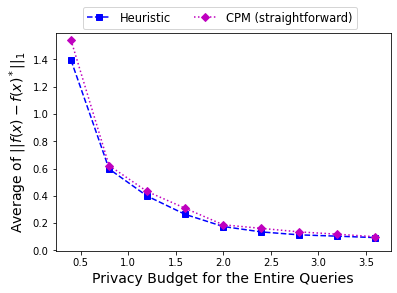

In [7]:
k = 2; m = [0,9,9]
run = 50
e = np.zeros((run,k+1))
for j in range(run):
    e[j] = [random.uniform(1,2) for l in range(k+1)]
    e[j][0] = 0


diff = evaluation(m,e,run,ATP)
print(diff)

s = [0.4,0.8,1.2,1.6,2.0,2.4,2.8,3.2,3.6]
fig = plt.figure()
plt.ylim(-0.003, max([max(diff[:,j]) for j in range(2)])+0.05)
plt.plot(s,diff[:,1],marker="s",color="blue",linestyle = "dashed",label="Heuristic")
plt.plot(s,diff[:,0],marker="D",color="m",linestyle = "dotted",label="CPM (straightforward)")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=2, fontsize=11.5)
plt.xlabel("Privacy Budget for the Entire Queries",fontsize=14)
plt.ylabel("Average of $||f(x) - f(x)^*||_1$",fontsize=14)
fig.savefig("Accuracy_realData_BR_smallerEpsilon.png")
fig.savefig("figs/Accuracy_realData_BR_smallerEpsilon.eps", bbox_inches="tight", pad_inches=0.05)